In [1]:
# Install dependencies (if not preinstalled)
!pip install torch matplotlib tqdm

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm


In [14]:
# Toy dataset
text = """hello help helium helicopter hero helpful hello help hero hello help"""
print(f"Dataset length: {len(text)} characters")

# Build character vocabulary
chars = sorted(list(set(text)))
vocab_size = len(chars)
print(f"Unique characters ({vocab_size}): {chars}")

# Character mappings
stoi = {ch: i for i, ch in enumerate(chars)}
itos = {i: ch for ch, i in stoi.items()}

def encode(s): return [stoi[c] for c in s]
def decode(l): return ''.join([itos[i] for i in l])


Dataset length: 68 characters
Unique characters (13): [' ', 'c', 'e', 'f', 'h', 'i', 'l', 'm', 'o', 'p', 'r', 't', 'u']


In [15]:
seq_length = 10   # smaller for tiny dataset
batch_size = 16
hidden_size = 128
epochs = 10
learning_rate = 0.003

data = torch.tensor(encode(text), dtype=torch.long)

# Batch creation
def get_batch(data, seq_len, batch_size):
    if len(data) <= seq_len + 1:
        raise ValueError(f"Data too short for seq_len={seq_len}. Please use a smaller seq_len or a larger dataset.")
    starts = torch.randint(0, len(data) - seq_len - 1, (batch_size,))
    inputs = [data[i:i+seq_len] for i in starts]
    targets = [data[i+1:i+seq_len+1] for i in starts]
    return torch.stack(inputs), torch.stack(targets)


In [16]:
class CharRNN(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_size):
        super(CharRNN, self).__init__()
        self.embed = nn.Embedding(vocab_size, embed_dim)
        self.lstm = nn.LSTM(embed_dim, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, vocab_size)

    def forward(self, x, hidden=None):
        x = self.embed(x)
        out, hidden = self.lstm(x, hidden)
        out = self.fc(out)
        return out, hidden

model = CharRNN(vocab_size, embed_dim=64, hidden_size=hidden_size)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


In [17]:
train_losses = []

for epoch in range(epochs):
    model.train()
    total_loss = 0
    for _ in range(100):  # 100 batches per epoch
        x_batch, y_batch = get_batch(data, seq_length, batch_size)
        optimizer.zero_grad()
        y_pred, _ = model(x_batch)
        loss = loss_fn(y_pred.transpose(1, 2), y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / 100
    print(f"Epoch {epoch+1}/{epochs} | Train Loss: {avg_loss:.4f}")
    train_losses.append(avg_loss)


Epoch 1/10 | Train Loss: 0.5702
Epoch 2/10 | Train Loss: 0.2011
Epoch 3/10 | Train Loss: 0.1843
Epoch 4/10 | Train Loss: 0.1829
Epoch 5/10 | Train Loss: 0.1786
Epoch 6/10 | Train Loss: 0.1803
Epoch 7/10 | Train Loss: 0.1778
Epoch 8/10 | Train Loss: 0.1820
Epoch 9/10 | Train Loss: 0.1764
Epoch 10/10 | Train Loss: 0.1772


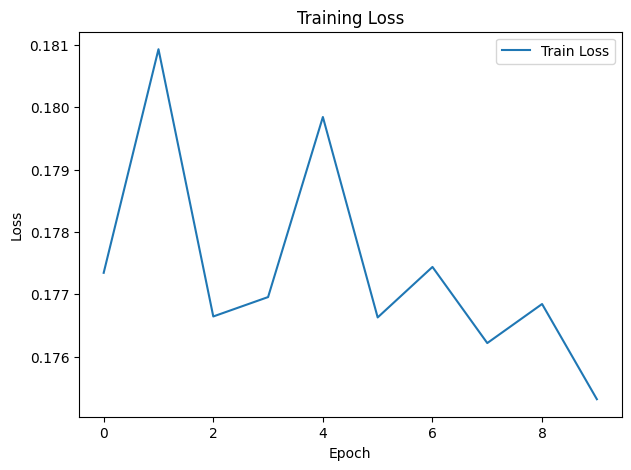

In [19]:
plt.figure(figsize=(7,5))
plt.plot(train_losses, label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.show()


In [20]:
def generate(model, start_text="h", length=200, temperature=1.0):
    model.eval()
    input_eval = torch.tensor([stoi[ch] for ch in start_text], dtype=torch.long).unsqueeze(0)
    hidden = None
    result = [ch for ch in start_text]

    with torch.no_grad():
        for _ in range(length):
            output, hidden = model(input_eval, hidden)
            logits = output[:, -1, :] / temperature
            probs = torch.softmax(logits, dim=-1)
            next_char = torch.multinomial(probs, num_samples=1).item()
            result.append(itos[next_char])
            input_eval = torch.tensor([[next_char]])

    return ''.join(result)

# Generate text at different temperatures
for temp in [0.7, 1.0, 1.2]:
    print(f"\n--- Generated (temperature={temp}) ---")
    print(generate(model, start_text="h", length=200, temperature=temp))



--- Generated (temperature=0.7) ---
helicopter hero help helium helicopter hero help hero hello hello help hero hello hello hello help helium helicopter hero help hero hello hello helpful hello hello hello help helium helicopter hero hel

--- Generated (temperature=1.0) ---
help hero hello hello hello help hero hello hello hello help helium helicopter hero helpful hello hello hello help helium helicopter hero help hero hello hello help hero hello hello help hero hello hel

--- Generated (temperature=1.2) ---
hero hello hello hello help hero hello hello hello help hero hello helpful hello hello hello help hero hello hello hello help hero hello hello help hero hello hello help hero hello hello help helium he


##Reflection:

Increasing sequence length allows capturing longer dependencies but increases memory usage and training time.

Larger hidden sizes improve model capacity and generate more coherent text but may overfit small datasets.

Temperature controls randomness: lower values (e.g., 0.7) yield more predictable text; higher values (e.g., 1.2) produce creative but sometimes incoherent sequences.